In [22]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
# Define constants and paths 
CAM_ALGORITHMS = ["GradCAM", "HiResCAM", "GradCAMPlusPlus", "XGradCAM", "LayerCAM"]
base_dir = "/home/z/Music/code/CAIN/results/imagenet/val_images10k_attack/pixelate/2/nvidia/mit-b0"
model_name = "Segformer"  # Replace with your actual model name
attack_name = "pixelate"  # Replace with your actual attack name
results_directory = os.path.join(base_dir, model_name, attack_name, "evaluation", "prediction_changes")

# Ensure the results directory exists
os.makedirs(results_directory, exist_ok=True)

# Function to read prediction scores from a text file
def read_scores_from_file(filepath):
    scores = {}
    with open(filepath, "r") as file:
        for line in file:
            parts = line.strip().split(' ')
            class_id = int(parts[1])  # Get the class ID
            score = parts[-1]  # Score is the last element after splitting
            try:
                score = float(score)  # Try converting the score to float
                scores[class_id] = score
            except ValueError as e:
                print(f"Error converting score to float: {e}, line: {line}")
    return scores


# Function to load images and corresponding prediction scores
def load_data_and_scores(root_path):
    data = []
    for label_folder in os.listdir(root_path):
        parts = label_folder.split('_')
        image_id = '_'.join(parts[:-1])
        image_label = parts[-1]
        original_score_path = os.path.join(root_path, label_folder, 'info.txt')
        masked_score_path = os.path.join(root_path, label_folder, 'info_masked.txt')
        original_scores = read_scores_from_file(original_score_path)
        masked_scores = read_scores_from_file(masked_score_path)
        data.append((image_id, image_label, original_scores, masked_scores))
    return data

# Function to calculate changes between scores
def calculate_changes(original_scores, masked_scores):
    changes = []
    percentages = []
    for class_id in original_scores:
        original_score = original_scores[class_id]
        masked_score = masked_scores.get(class_id, 0)
        change = original_score - masked_score
        percentage = change / original_score if original_score != 0 else 0
        changes.append(change)
        percentages.append(percentage)
    return changes, percentages

# def calculate_topn_changes(original_scores, masked_scores, n=5):
#     # 对原始得分进行排序以找到Top-N类别和得分
#     topn_classes = sorted(original_scores, key=lambda x: abs(original_scores[x]), reverse=True)[:n]
    
#     # 初始化变化和百分比的列表
#     changes = []
#     percentages = []
    
#     # 遍历Top-N类别
#     for class_id in topn_classes:
#         # 获取原始和遮罩后的得分
#         original_score = original_scores[class_id]
#         masked_score = masked_scores.get(class_id, 0)
        
#         # 计算变化和变化百分比
#         change = abs(original_score - masked_score)
#         percentage = (abs(change) / abs(original_score)) if original_score != 0 else 0
        
#         # 将变化和变化百分比添加到列表中
#         changes.append((class_id, change, percentage))
    
#     # 计算平均变化和变化百分比
#     average_change = sum(change for _, change, _ in changes) / len(changes)
#     average_percentage = sum(percentage for _, _, percentage in changes) / len(changes)
    
#     return changes, average_change, average_percentage


def calculate_topn_changes(original_scores, masked_scores, n=5):

    topn_classes = sorted(original_scores, key=lambda x: original_scores[x], reverse=True)[:n]

    changes = []
    percentages = []

    for class_id in topn_classes:

        original_score = original_scores[class_id]
        masked_score = masked_scores.get(class_id, 0)
        

        change = original_score - masked_score

        max_score = max(abs(original_score), abs(masked_score))
        percentage = (abs(change) / max_score) if max_score != 0 else 0
        

        changes.append((class_id, change, percentage))

    average_change = np.mean([change for _, change, _ in changes])
    average_percentage = np.mean([percentage for _, _, percentage in changes])
    
    return changes, average_change, average_percentage


def save_results_to_csv(results, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        fieldnames = ['CAM_Algorithm', 'Average_Change', 'Average_Percentage_Change', 'Q25_Change', 'Median_Change', 'Q75_Change', 'Q25_Percentage', 'Median_Percentage', 'Q75_Percentage']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for CAM_Algorithm, stats in results.items():
            writer.writerow({
                'CAM_Algorithm': CAM_Algorithm,
                'Average_Change': stats['mean_changes'],
                'Average_Percentage_Change': stats['mean_percentages'],
                'Q25_Change': stats['q25_changes'],
                'Median_Change': stats['median_changes'],
                'Q75_Change': stats['q75_changes'],
                'Q25_Percentage': stats['q25_percentages'],
                'Median_Percentage': stats['median_percentages'],
                'Q75_Percentage': stats['q75_percentages']
            })

# Process each CAM algorithm
all_top1_changes = {}
all_topn_changes = {}
for CAM_Algorithm in CAM_ALGORITHMS:
    print(f"Processing {CAM_Algorithm}...")
    dataset_path = f"{base_dir}/{CAM_Algorithm}"
    dataset = load_data_and_scores(dataset_path)
    
    all_top1_changes_per_algorithm = []
    all_topn_changes_per_algorithm = []
    for image_id, label, original_scores, masked_scores in tqdm(dataset):
        # 计算Top-1和Top-N的变化
        top1_changes, top1_average_change, top1_average_percentage = calculate_topn_changes(original_scores, masked_scores, n=1)
        topn_changes, topn_average_change, topn_average_percentage = calculate_topn_changes(original_scores, masked_scores, n=5)
        
        # 只关注Top-1的变化和百分比
        all_top1_changes_per_algorithm.append(top1_changes[0])
        
        # 聚集所有Top-N的变化和百分比
        all_topn_changes_per_algorithm.extend(topn_changes)
    
    # 存储每个算法的Top-1和Top-N变化
    all_top1_changes[CAM_Algorithm] = {
        'changes': [change for _, change, _ in all_top1_changes_per_algorithm],
        'percentages': [percentage for _, _, percentage in all_top1_changes_per_algorithm]
    }
    all_topn_changes[CAM_Algorithm] = {
        'changes': [change for _, change, _ in all_topn_changes_per_algorithm],
        'percentages': [percentage for _, _, percentage in all_topn_changes_per_algorithm]
    }

results_statistics_top1 = {}
results_statistics_topn = {}

# 对每个CAM算法处理并计算统计信息
for CAM_Algorithm in CAM_ALGORITHMS:
    # 对于Top-1
    top1_changes = all_top1_changes[CAM_Algorithm]['changes']
    top1_percentages = all_top1_changes[CAM_Algorithm]['percentages']
    top1_stats = {
        'mean_changes': np.mean(top1_changes),
        'mean_percentages': np.mean(top1_percentages),
        'q25_changes': np.percentile(top1_changes, 25),
        'median_changes': np.median(top1_changes),
        'q75_changes': np.percentile(top1_changes, 75),
        'q25_percentages': np.percentile(top1_percentages, 25),
        'median_percentages': np.median(top1_percentages),
        'q75_percentages': np.percentile(top1_percentages, 75),
    }
    results_statistics_top1[CAM_Algorithm] = top1_stats
    print(f"Top-1 Statistics for {CAM_Algorithm}: {results_statistics_top1[CAM_Algorithm]}")

    # 对于Top-N
    topn_changes = all_topn_changes[CAM_Algorithm]['changes']
    topn_percentages = all_topn_changes[CAM_Algorithm]['percentages']
    topn_stats = {
        'mean_changes': np.mean(topn_changes),
        'mean_percentages': np.mean(topn_percentages),
        'q25_changes': np.percentile(topn_changes, 25),
        'median_changes': np.median(topn_changes),
        'q75_changes': np.percentile(topn_changes, 75),
        'q25_percentages': np.percentile(topn_percentages, 25),
        'median_percentages': np.median(topn_percentages),
        'q75_percentages': np.percentile(topn_percentages, 75),
    }
    results_statistics_topn[CAM_Algorithm] = topn_stats
    print(f"Top-N Statistics for {CAM_Algorithm}: {results_statistics_topn[CAM_Algorithm]}")

# 保存结果到CSV文件
def save_results_to_csv(results, file_path, top_n):
    with open(file_path, 'w', newline='') as csvfile:
        fieldnames = ['CAM_Algorithm', 'Top_N', 'Average_Change', 'Average_Percentage_Change', 'Q25_Change', 'Median_Change', 'Q75_Change', 'Q25_Percentage', 'Median_Percentage', 'Q75_Percentage']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for CAM_Algorithm, stats in results.items():
            writer.writerow({
                'CAM_Algorithm': CAM_Algorithm,
                'Top_N': top_n,
                'Average_Change': stats['mean_changes'],
                'Average_Percentage_Change': stats['mean_percentages'],
                'Q25_Change': stats['q25_changes'],
                'Median_Change': stats['median_changes'],
                'Q75_Change': stats['q75_changes'],
                'Q25_Percentage': stats['q25_percentages'],
                'Median_Percentage': stats['median_percentages'],
                'Q75_Percentage': stats['q75_percentages']
            })

# 保存Top-1统计信息
results_csv_path_top1 = os.path.join(results_directory, 'prediction_changes_statistics_top1.csv')
save_results_to_csv(results_statistics_top1, results_csv_path_top1, 1)

# 保存Top-N统计信息
results_csv_path_topn = os.path.join(results_directory, 'prediction_changes_statistics_topn.csv')
save_results_to_csv(results_statistics_topn, results_csv_path_topn, 5)




Processing GradCAM...


100%|██████████| 10000/10000 [00:00<00:00, 30452.85it/s]


Processing HiResCAM...


100%|██████████| 10000/10000 [00:00<00:00, 26536.97it/s]


Processing GradCAMPlusPlus...


100%|██████████| 10000/10000 [00:00<00:00, 29333.87it/s]


Processing XGradCAM...


100%|██████████| 10000/10000 [00:00<00:00, 28048.58it/s]


Processing LayerCAM...


100%|██████████| 10000/10000 [00:00<00:00, 30464.15it/s]


Top-1 Statistics for GradCAM: {'mean_changes': 0.8828590000000001, 'mean_percentages': 0.38328452110904226, 'q25_changes': 0.33, 'median_changes': 0.8899999999999997, 'q75_changes': 1.45, 'q25_percentages': 0.1728957923967587, 'median_percentages': 0.3442379724667996, 'q75_percentages': 0.5518867924528302}
Top-N Statistics for GradCAM: {'mean_changes': 0.798785, 'mean_percentages': 0.4083309307938783, 'q25_changes': 0.2799999999999998, 'median_changes': 0.7999999999999998, 'q75_changes': 1.3199999999999998, 'q25_percentages': 0.18066549200325288, 'median_percentages': 0.363992337164751, 'q75_percentages': 0.5895630230351134}
Top-1 Statistics for HiResCAM: {'mean_changes': 0.88285, 'mean_percentages': 0.38328359063800427, 'q25_changes': 0.32999999999999985, 'median_changes': 0.8899999999999997, 'q75_changes': 1.45, 'q25_percentages': 0.17261149383611316, 'median_percentages': 0.3442379724667996, 'q75_percentages': 0.5518867924528302}
Top-N Statistics for HiResCAM: {'mean_changes': 0.798

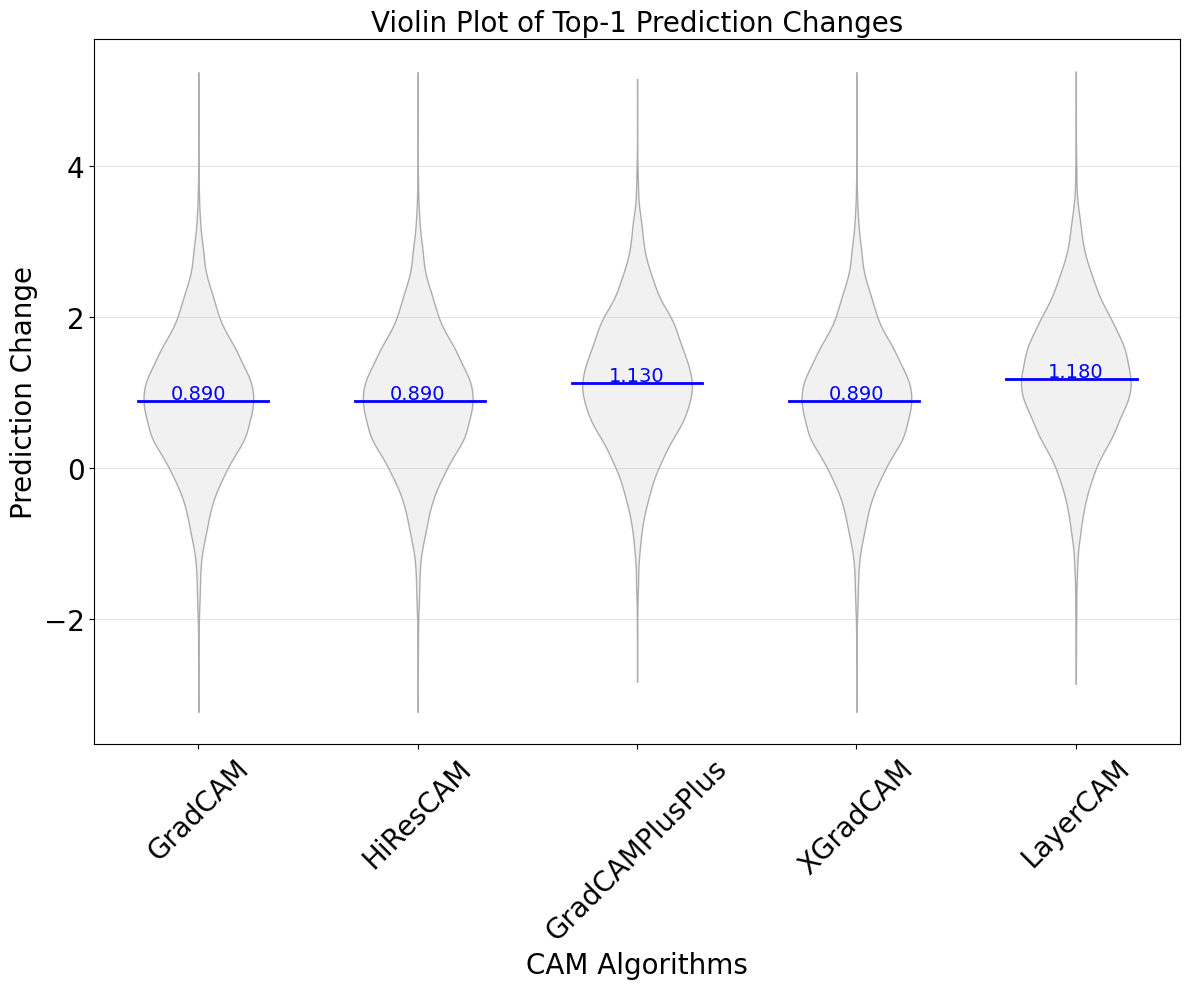

In [23]:
# 绘制Top-1变化的小提琴图
plt.figure(figsize=(12, 10))
top1_violins = plt.violinplot([all_top1_changes[cam]['changes'] for cam in CAM_ALGORITHMS], showmeans=False, showmedians=False, showextrema=False)
plt.title("Violin Plot of Top-1 Prediction Changes", fontsize=20)
plt.ylabel("Prediction Change", fontsize=20)
plt.xlabel("CAM Algorithms", fontsize=20)

# 配置小提琴图颜色
for body in top1_violins['bodies']:
    body.set_facecolor('#D3D3D3')
    body.set_edgecolor('black')

# 突出显示中位数
top1_medians = [np.median(all_top1_changes[cam]['changes']) for cam in CAM_ALGORITHMS]
for i, median in enumerate(top1_medians, 1):
    plt.axhline(y=median, color='blue', linewidth=2, xmin=(i-1+0.2)/len(CAM_ALGORITHMS), xmax=(i-0.2)/len(CAM_ALGORITHMS))
    plt.text(i, median + 0.02, f"{median:.3f}", color='blue', ha='center', fontsize=14)

# 设置X轴标签
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=14, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(results_directory, "violin_plot_top1_prediction_changes.png"), dpi=300)
plt.show()


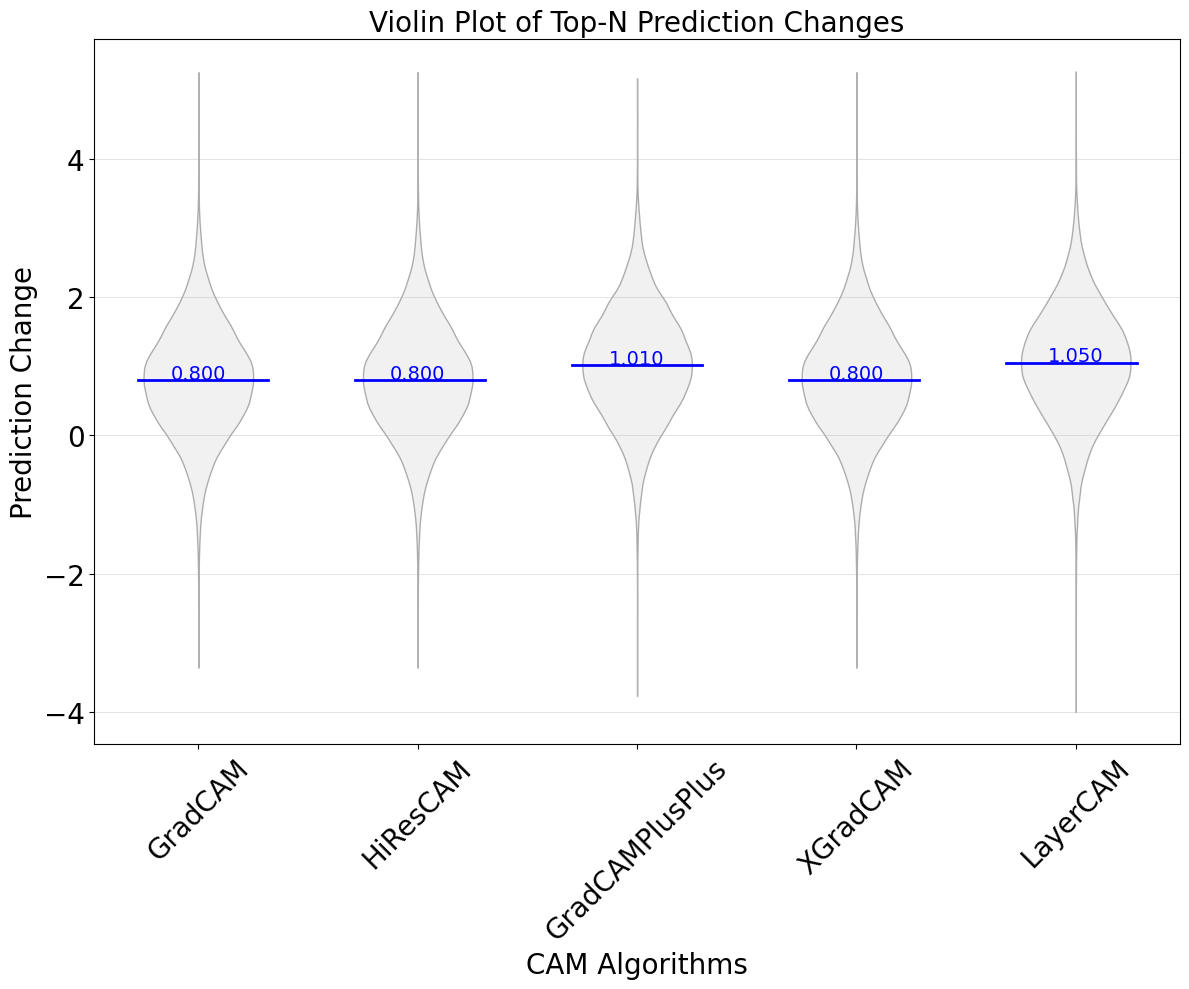

In [24]:
# 绘制Top-N变化的小提琴图
plt.figure(figsize=(12, 10))
topn_violins = plt.violinplot([all_topn_changes[cam]['changes'] for cam in CAM_ALGORITHMS], showmeans=False, showmedians=False, showextrema=False)
plt.title("Violin Plot of Top-N Prediction Changes", fontsize=20)
plt.ylabel("Prediction Change", fontsize=20)
plt.xlabel("CAM Algorithms", fontsize=20)

# 配置小提琴图颜色
for body in topn_violins['bodies']:
    body.set_facecolor('#D3D3D3')
    body.set_edgecolor('black')

# 突出显示中位数
topn_medians = [np.median(all_topn_changes[cam]['changes']) for cam in CAM_ALGORITHMS]
for i, median in enumerate(topn_medians, 1):
    plt.axhline(y=median, color='blue', linewidth=2, xmin=(i-1+0.2)/len(CAM_ALGORITHMS), xmax=(i-0.2)/len(CAM_ALGORITHMS))
    plt.text(i, median + 0.02, f"{median:.3f}", color='blue', ha='center', fontsize=14)

# 设置X轴标签
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=14, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(results_directory, "violin_plot_topn_prediction_changes.png"), dpi=300)
plt.show()


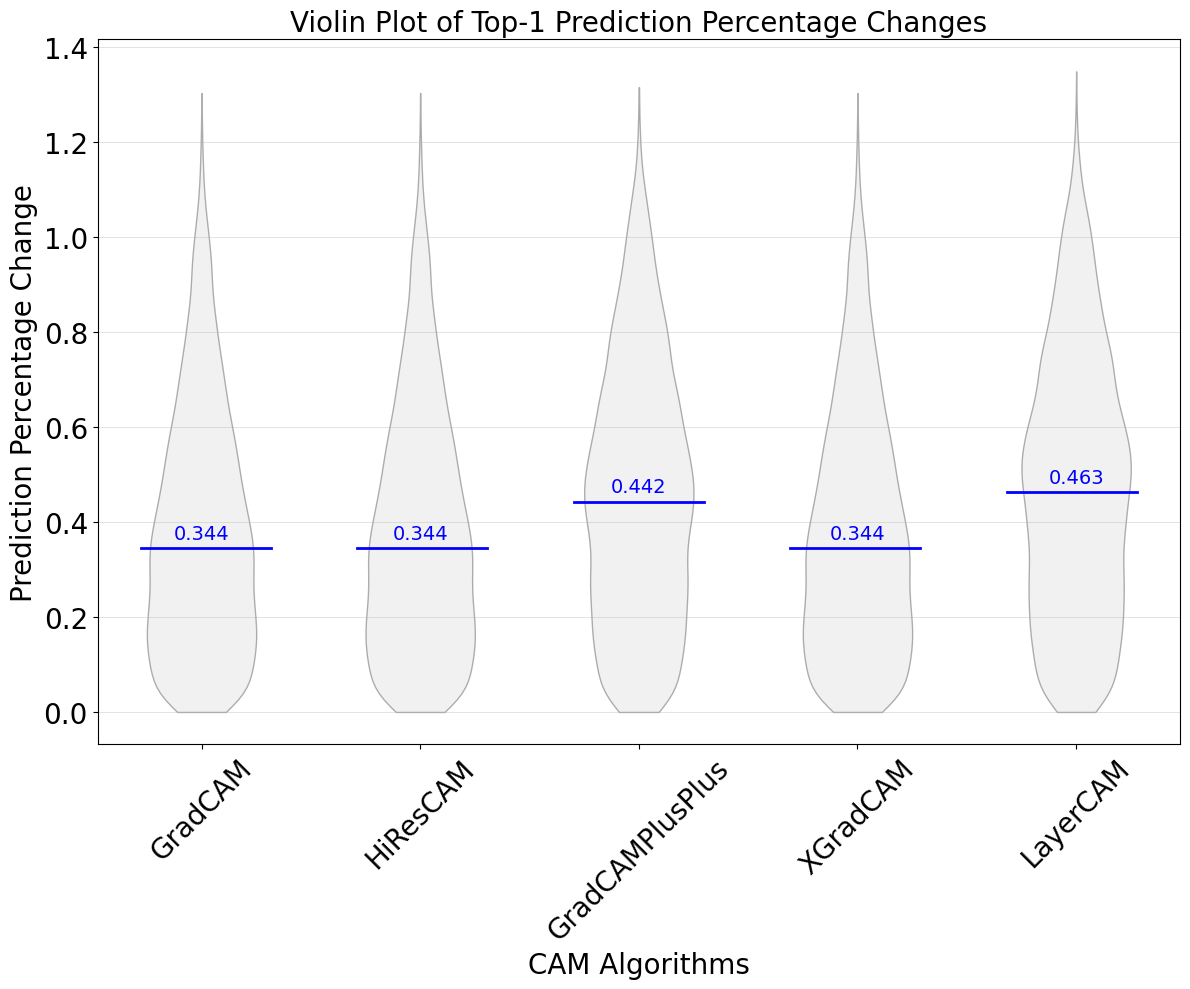

In [25]:
# 绘制Top-1变化的小提琴图
plt.figure(figsize=(12, 10))
top1_violins = plt.violinplot([all_top1_changes[cam]['percentages'] for cam in CAM_ALGORITHMS], showmeans=False, showmedians=False, showextrema=False)
plt.title("Violin Plot of Top-1 Prediction Percentage Changes", fontsize=20)
plt.ylabel("Prediction Percentage Change", fontsize=20)
plt.xlabel("CAM Algorithms", fontsize=20)

# 配置小提琴图颜色
for body in top1_violins['bodies']:
    body.set_facecolor('#D3D3D3')
    body.set_edgecolor('black')

# 突出显示中位数
top1_medians = [np.median(all_top1_changes[cam]['percentages']) for cam in CAM_ALGORITHMS]
for i, median in enumerate(top1_medians, 1):
    plt.axhline(y=median, color='blue', linewidth=2, xmin=(i-1+0.2)/len(CAM_ALGORITHMS), xmax=(i-0.2)/len(CAM_ALGORITHMS))
    plt.text(i, median + 0.02, f"{median:.3f}", color='blue', ha='center', fontsize=14)

# 设置X轴标签
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=14, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(results_directory, "violin_plot_top1_prediction_percentage_changes.png"), dpi=300)
plt.show()


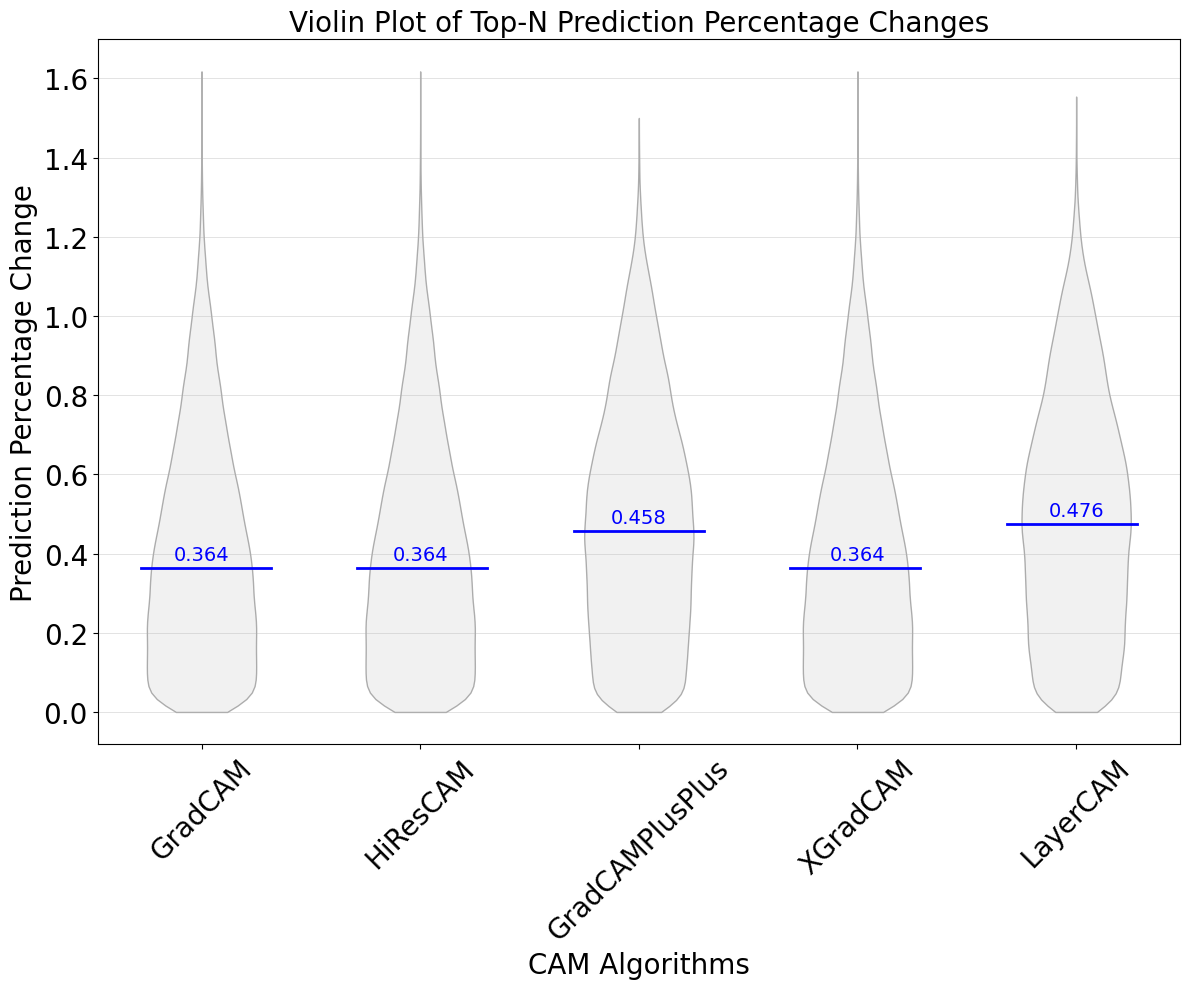

In [26]:
# 绘制Top-N变化的小提琴图
plt.figure(figsize=(12, 10))
topn_violins = plt.violinplot([all_topn_changes[cam]['percentages'] for cam in CAM_ALGORITHMS], showmeans=False, showmedians=False, showextrema=False)
plt.title("Violin Plot of Top-N Prediction Percentage Changes", fontsize=20)
plt.ylabel("Prediction Percentage Change", fontsize=20)
plt.xlabel("CAM Algorithms", fontsize=20)

# 配置小提琴图颜色
for body in topn_violins['bodies']:
    body.set_facecolor('#D3D3D3')
    body.set_edgecolor('black')

# 突出显示中位数
topn_medians = [np.median(all_topn_changes[cam]['percentages']) for cam in CAM_ALGORITHMS]
for i, median in enumerate(topn_medians, 1):
    plt.axhline(y=median, color='blue', linewidth=2, xmin=(i-1+0.2)/len(CAM_ALGORITHMS), xmax=(i-0.2)/len(CAM_ALGORITHMS))
    plt.text(i, median + 0.02, f"{median:.3f}", color='blue', ha='center', fontsize=14)

# 设置X轴标签
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=14, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# 指定保存图像的路径
topn_violin_plot_path = os.path.join(results_directory, "violin_plot_topn_prediction_percentage_changes.png")

# 保存小提琴图
plt.savefig(topn_violin_plot_path, dpi=300)

# 展示图像
plt.show()
